<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/visualizing_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visualizing imputed dataset (imputed by crude backfilling)


In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/df_imputed_week_shift.csv", index_col = 0, parse_dates = True)

In [0]:
cols = ["speed", "flow", "speed_-2", "speed_-1","speed_+1", "speed_+2", "flow_-2", "flow_-1", "flow_+1", "flow_+2", "speed_limit"]
speed_cols = ["speed", "speed_-2", "speed_-1","speed_+1", "speed_+2"]
flow_cols = ["flow", "flow_-2", "flow_-1", "flow_+1", "flow_+2"]

In [0]:
import numpy as np
def resample_df(df, freq = "D", method_speed = np.mean, method_flow = np.sum):
    copied = df.resample(freq).agg({
           "speed": method_speed, "speed_-2": method_speed, "speed_-1": method_speed, "speed_+1": method_speed, "speed_+2": method_speed,
           "flow": method_flow, "flow_-2": method_flow, "flow_-1": method_flow, "flow_+1": method_flow, "flow_+2": method_flow})
    return copied

In [0]:
df_D = resample_df(df, method_speed = np.mean)
df_W = resample_df(df, freq = "W", method_speed = np.mean)

Visualize unimputed df

In [0]:
df_raw = pd.read_csv("data/combined_df.csv", index_col = 0, parse_dates = True)

In [0]:
raw = df_raw[["speed", "flow", "speed_limit"]].copy()
raw["not_null"] = np.where(((raw.speed.notnull()) | (raw.flow.notnull())), 1, np.nan)
rawres = raw.resample("W").agg({"speed": np.mean, "flow": np.sum, "speed_limit": np.median, "not_null": np.sum})

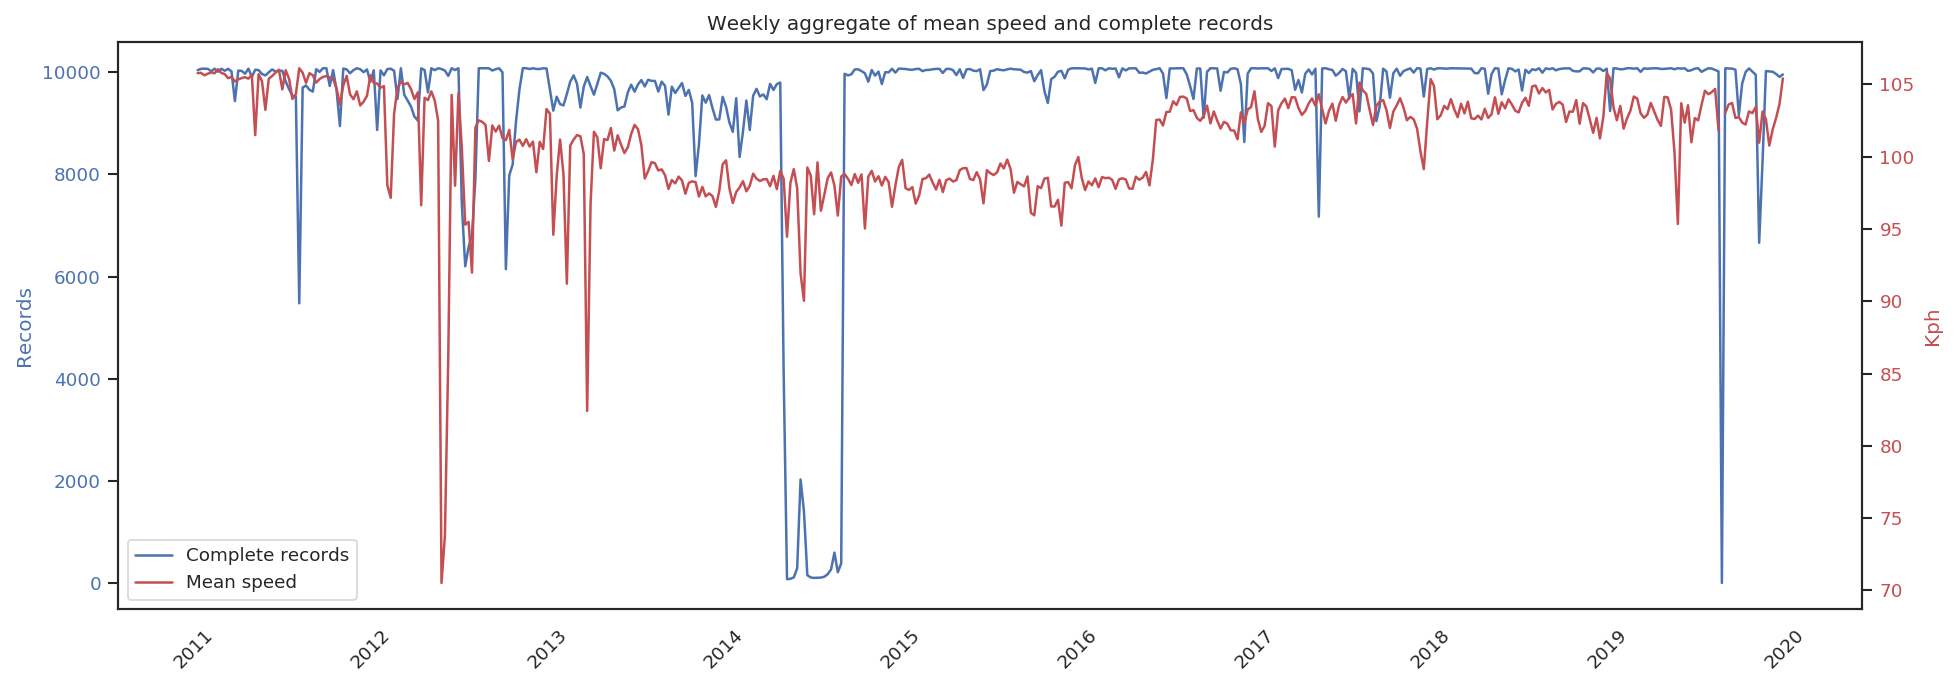

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

x, y1, y2 = rawres.index, rawres.not_null, rawres.speed

plt.rcParams["figure.dpi"] = 150
sns.set(context="paper", style="white")
fig, ax1 = plt.subplots(figsize = (15, 5))
ax1.set_title("Weekly aggregate of mean speed and complete records")
ax1.plot(x, y1, "b-", label = "Complete records")
ax1.set_ylabel("Records", color="b")
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for tick in ax1.get_yticklabels():
    tick.set_color("b")
# create second ax in same fig, sharing x-axis with ax1
ax2 = ax1.twinx()
ax2.plot(x, y2, "r-", label = "Mean speed")
ax2.set_ylabel("Kph", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

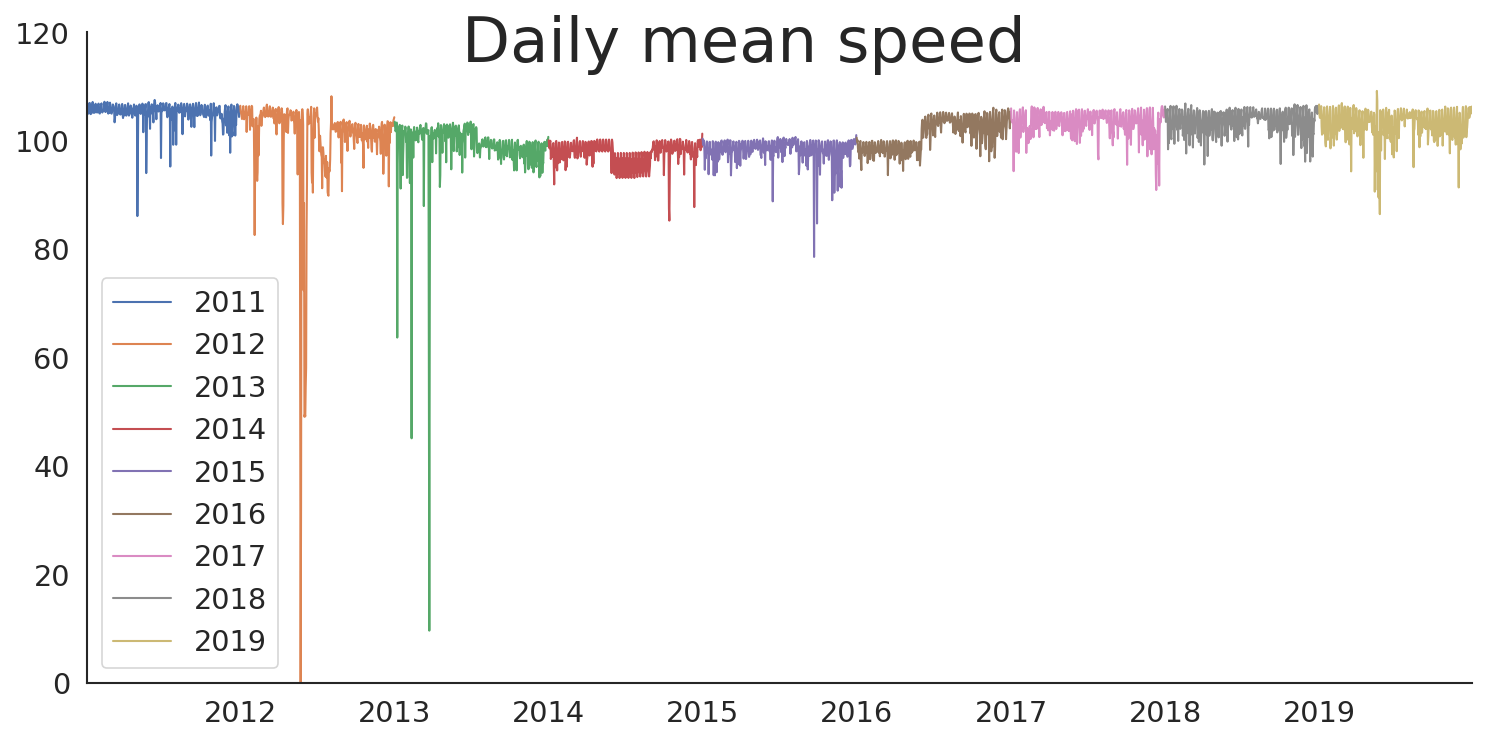

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 150

params = {"legend.fontsize": "x-large", "figure.figsize": (10, 5), "axes.labelsize": "x-large", "xtick.labelsize":"x-large", "ytick.labelsize":"x-large"}
plt.rcParams.update(params)

fig, ax = plt.subplots(sharey = True)
fig.suptitle("Daily mean speed", fontsize = 30)
ax.set_ylim(0, 120)
for i, year in enumerate(range(2011, 2020)):
    df_D[(df_D.index.year == year)]["speed"].plot(ax = ax, label = year, lw = 1)
ax.legend()
sns.despine()
plt.tight_layout()

In [0]:
fig.savefig("plots/Daily_speed_mean.png", dpi = 600)

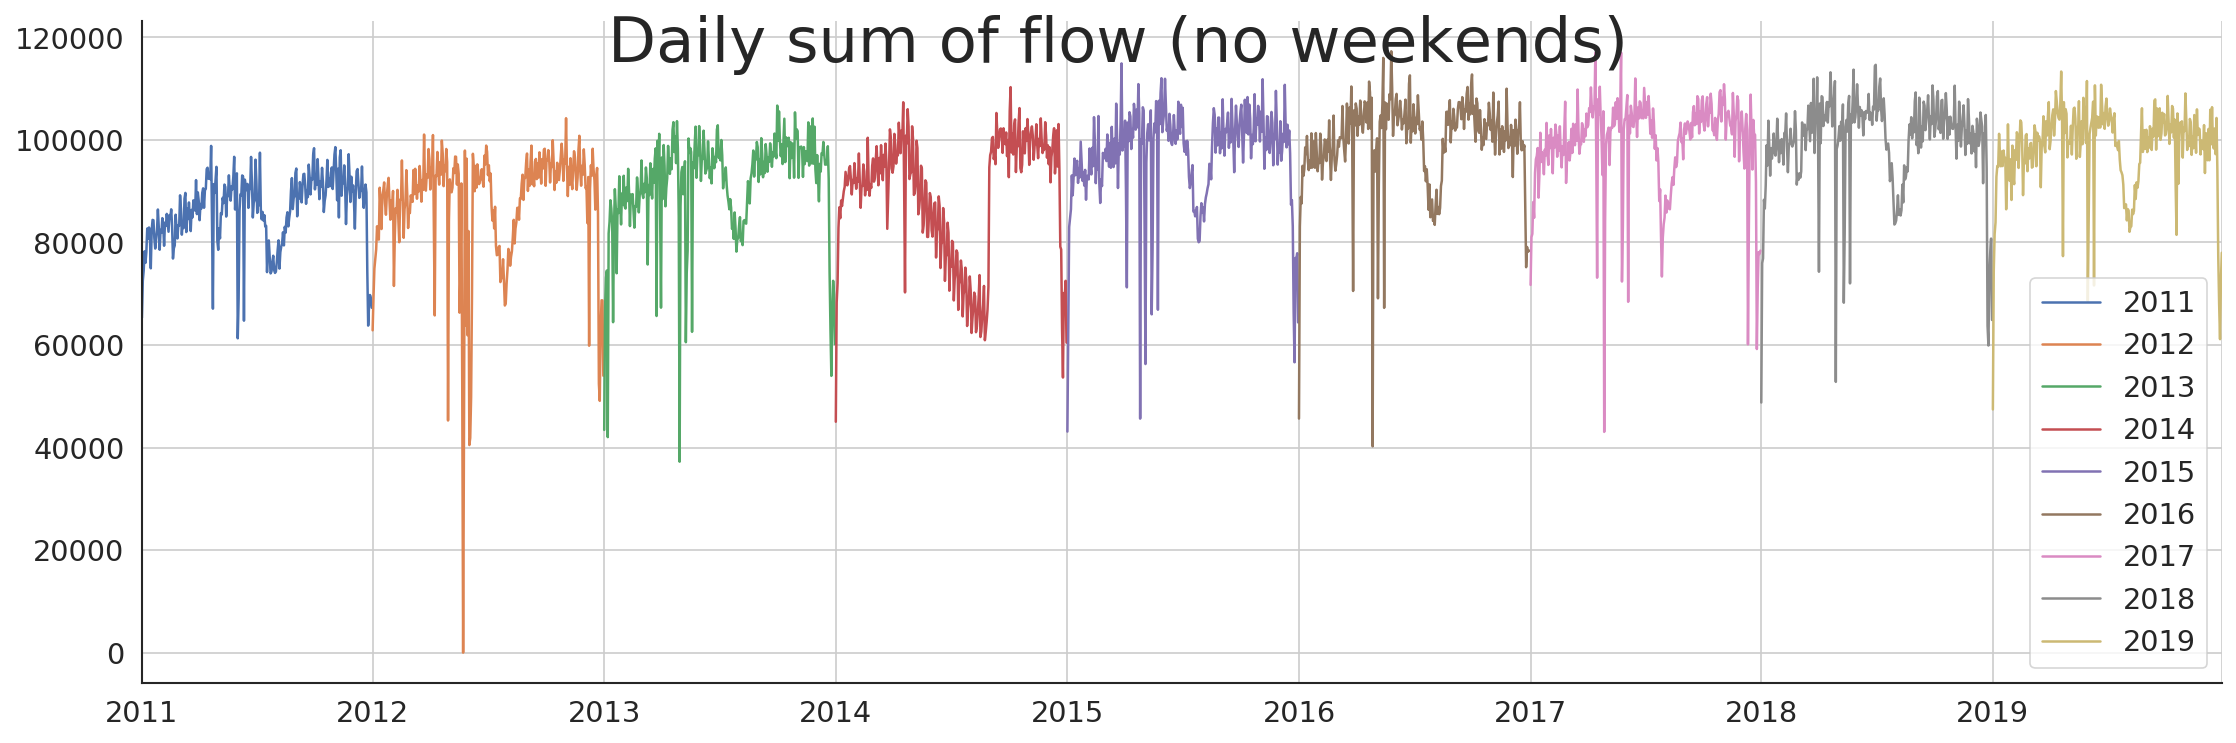

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (15, 5), sharey = True)
fig.suptitle("Daily sum of flow (no weekends)", fontsize = 30)

for i, year in enumerate(range(2011, 2020)):
    df_D[(df_D.index.year == year) & (df_D.index.dayofweek != 5) & (df_D.index.dayofweek != 6)]["flow"].plot(ax = ax, label = year)
plt.grid(True)
ax.legend()
sns.despine()
plt.tight_layout()

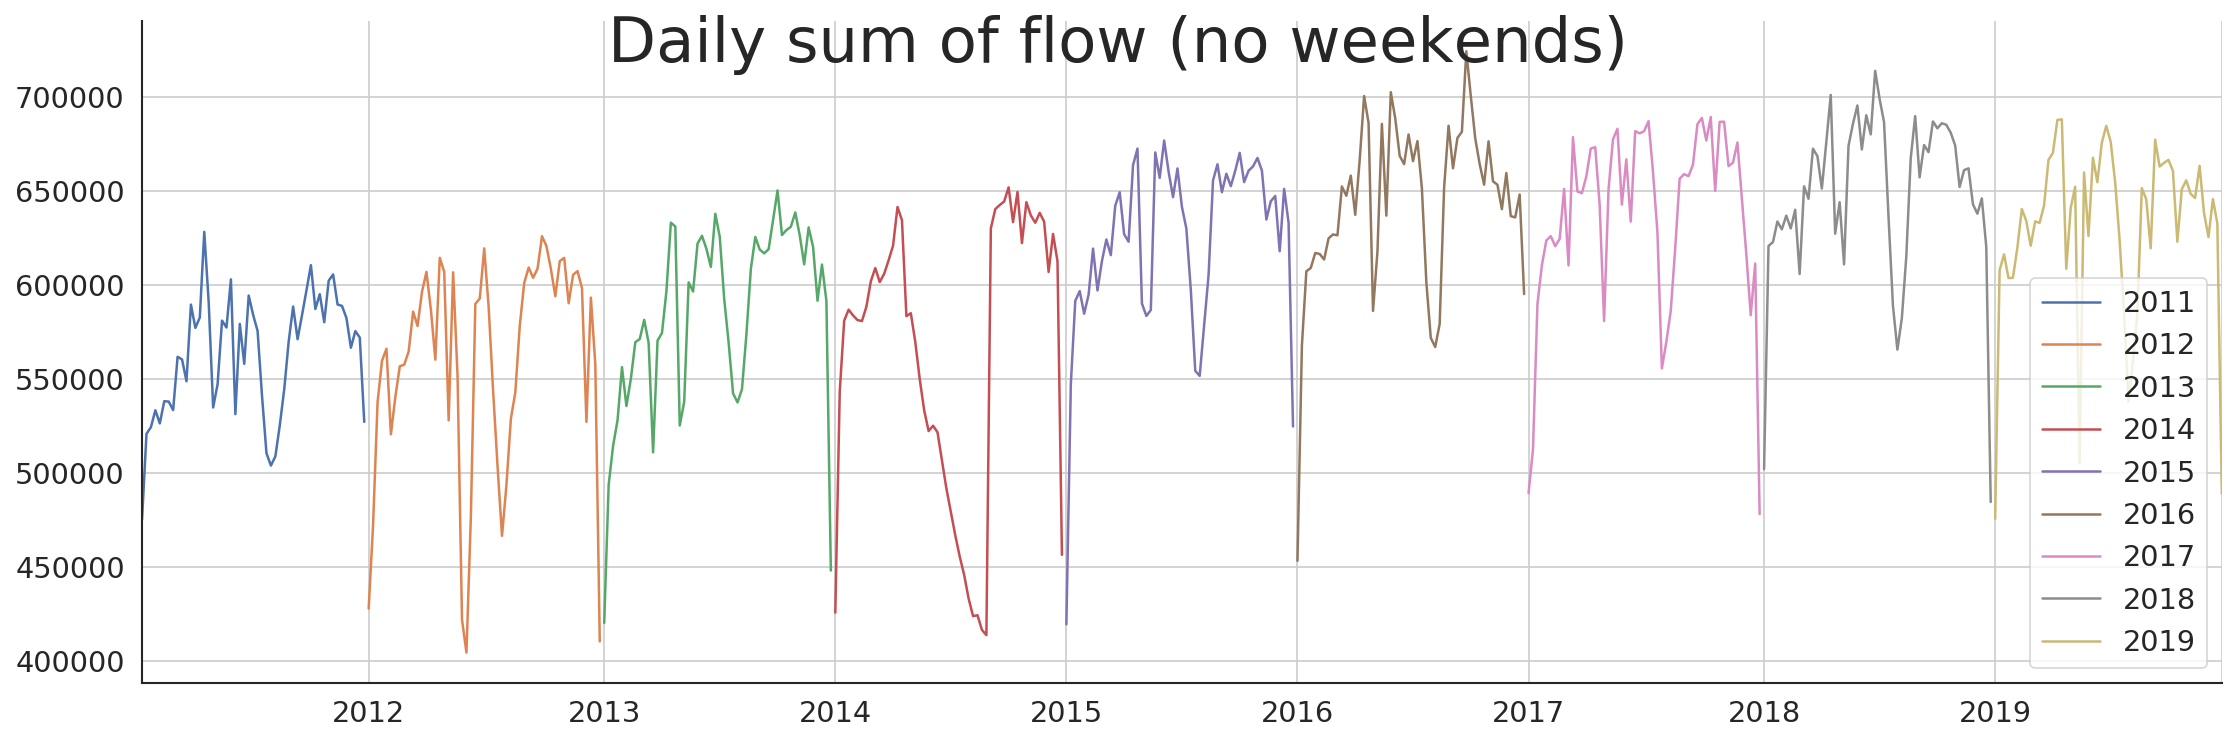

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (15, 5), sharey = True)
fig.suptitle("Daily sum of flow (no weekends)", fontsize = 30)

for i, year in enumerate(range(2011, 2020)):
    df_W[(df_W.index.year == year)]["flow"].plot(ax = ax, label = year)
plt.grid(True)
ax.legend()
sns.despine()
plt.tight_layout()

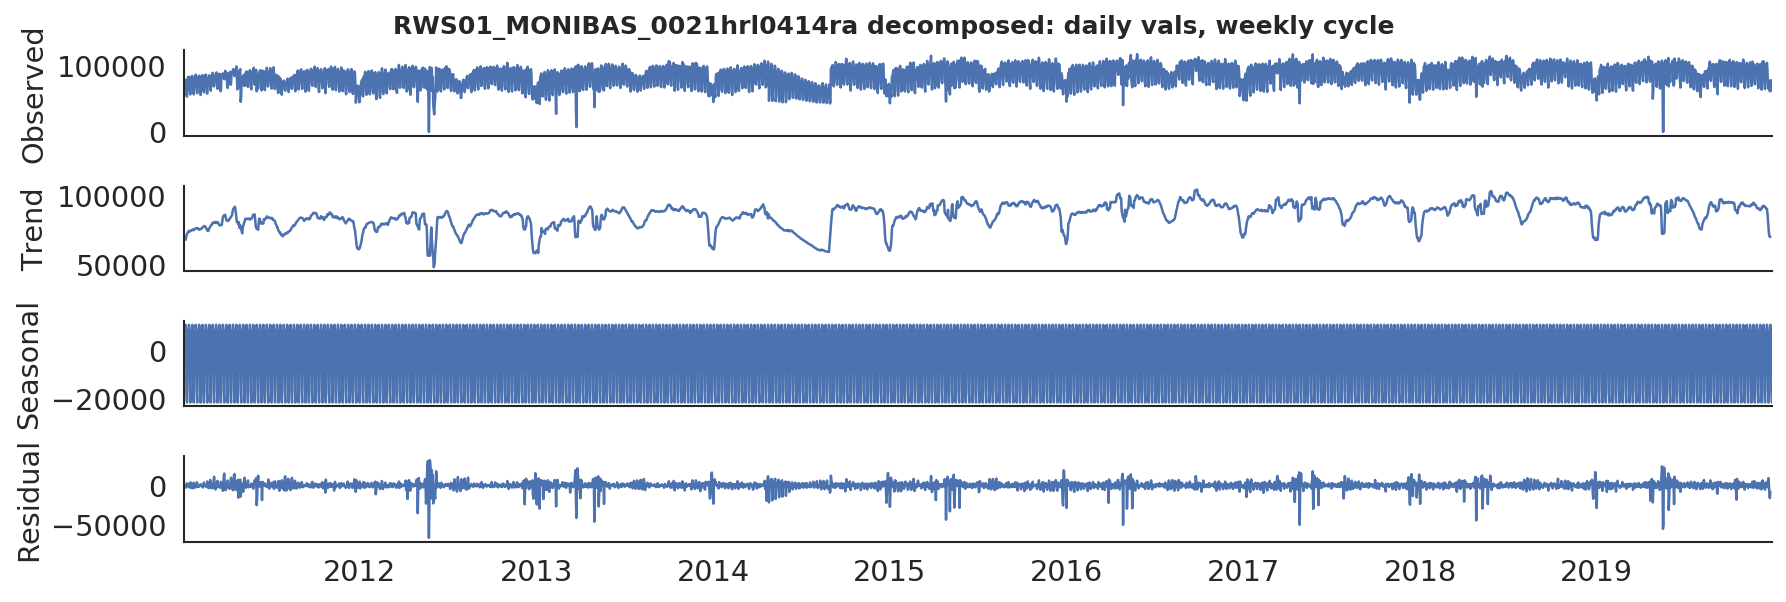

In [16]:
# Plot seasonal decomposition
import statsmodels.tsa.api as smt

y = df_D.flow

decomp = smt.seasonal_decompose(y, model = "additive", freq = 7)
fig =  plt.figure(figsize = (12, 4))
fig.suptitle(f"RWS01_MONIBAS_0021hrl0414ra decomposed: daily vals, weekly cycle", fontsize = 12, fontweight = "bold", y = 0.990)
layout = (4, 1)
observed_ax = plt.subplot2grid(layout, (0, 0)); trend_ax = plt.subplot2grid(layout, (1, 0)); seasonal_ax = plt.subplot2grid(layout, (2, 0)); residual_ax = plt.subplot2grid(layout, (3, 0))
observed_ax.set_ylabel("Observed"); trend_ax.set_ylabel("Trend"); seasonal_ax.set_ylabel("Seasonal"); residual_ax.set_ylabel("Residual")
observed_ax.get_shared_x_axes().join(observed_ax, trend_ax, seasonal_ax, residual_ax)

decomp.observed.plot(ax = observed_ax)
decomp.trend.plot(ax = trend_ax)
decomp.seasonal.plot(ax = seasonal_ax)
decomp.resid.plot(ax = residual_ax)
sns.despine()
plt.tight_layout()
plt.show()

In [0]:
import statsmodels.tsa.api as smt
def correlation_plot(y, title, lags=None, figsize=(16, 9)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight="bold")
    y.plot(ax=hist_ax, kind="hist", bins=120)
    hist_ax.set_title("Histogram")
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return fig, ts_ax, acf_ax, pacf_ax

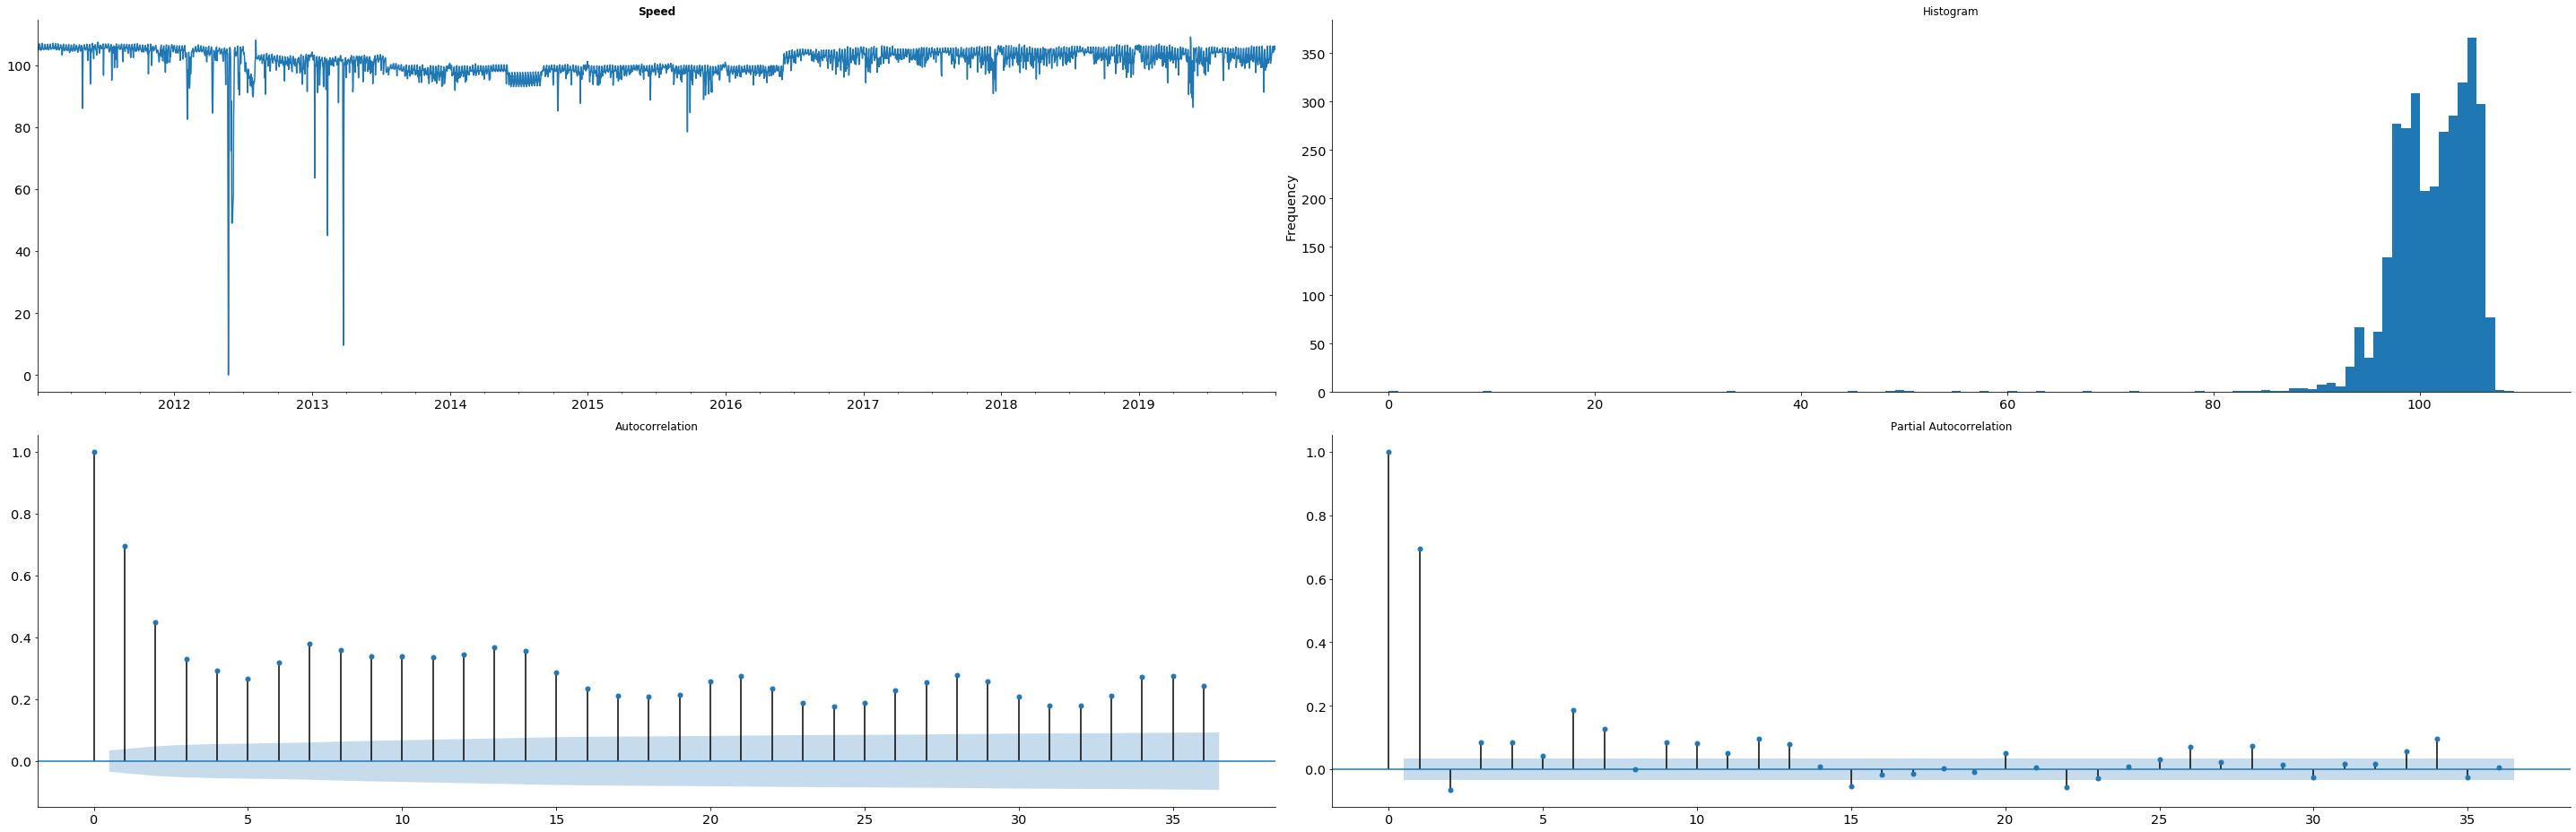

In [0]:
fig = correlation_plot(df_D.speed, "Speed", figsize = (40,13))[0]
plt.show()